## Imports

In [8]:
# offizielle libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lmfit.models import Model
%matplotlib inline

In [9]:
# selbstgeschrieben
import file_organizer as fo
from func import get_norm_cm
from func import ticks_handle

## FID

In [10]:
path = "data_day_two"
file_list = fo.load_file_list(path)
selection = fo.select_files(file_list, "meas", "J")
data = fo.load_files(selection)
data = fo.df_combine(data)
del data["iout"]
data["time"] = data["time"] * 1000
labels = list(data.columns)
labels.remove('time')

In [11]:
def fit_t2s(t, y, log=False):
    def t2func(t, M0, T2,c):#
        return M0*np.exp(-t/T2)+c

    model = Model(t2func, nan_policy='omit')
    res = model.fit(y, t=t, M0=1, T2=20,c=0)
    if log: print(res.fit_report())
    return res

In [12]:
zero = data[labels[0]].abs().idxmax() 
end = (data['time']-18).abs().idxmin()
res = fit_t2s(np.array(data.loc[zero:end, 'time']), np.array(data.loc[zero:end, labels[0]]), log=False)

[[Model]]
    Model(t2func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 3970
    # variables        = 3
    chi-square         = 25.7801073
    reduced chi-square = 0.00649864
    Akaike info crit   = -19990.5653
    Bayesian info crit = -19971.7057
[[Variables]]
    M0:  9.19268580 +/- 0.00820724 (0.09%) (init = 1)
    T2:  1.87367526 +/- 0.00270537 (0.14%) (init = 20)
    c:   0.31133819 +/- 0.00175758 (0.56%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(M0, T2) = -0.638
    C(T2, c)  = -0.554


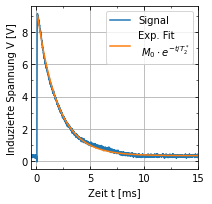

In [13]:
fig,ax=plt.subplots(figsize=(3,3))
ax.plot(data['time'], data[labels[0]], label='Signal')
ax.plot(data.loc[zero+2:end, 'time'], res.best_fit, label='Exp. Fit\n $M_0\\cdot e^{{-t/T_2^*}}$')

ax.set_xlabel("Zeit t [ms]")
ax.set_ylabel("Induzierte Spannung V [V]")
ax.set_xlim(-0.5, 15)
ax.grid()
ax.legend()
ticks_handle(ax, which='both')
fig.savefig('IMAGES/lmo_fid_fit.png', dpi=300)
print(res.fit_report())

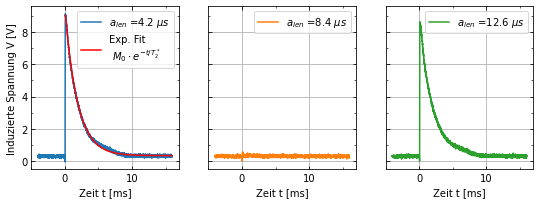

In [14]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
fig, axs = plt.subplots(1,3,figsize=(9,3), sharey=True)

for i in range(3):
    data.plot(x='time',y=labels[i], ax=axs[i], color=colors[i], label=f'$a_{{len}}$ ={selection[i].A} $\\mu s$')
    axs[i].set_xlabel("Zeit t [ms]")
    axs[i].set_ylabel("Induzierte Spannung V [V]")
    axs[i].grid()
    ticks_handle(axs[i], which='both')
    axs[i].legend()
axs[0].plot(data.loc[zero+2:end, 'time'], res.best_fit,color='red', label='Exp. Fit\n $M_0\\cdot e^{{-t/T_2^*}}$')
axs[0].legend()
fig.savefig('IMAGES/lmo_fid.png', dpi=300,bbox_inches='tight')

## T1 aus Periode

Daten von Tag 1
&gt; path = 'data_day_one'; meas = E
zu kleine Zeiten P

Daten von Tag 2
&gt; path = 'data_day_two', meas = K;

In [15]:
# Neuer Versuch
path = "data_day_two"
file_list = fo.load_file_list(path)
selection = fo.select_files(file_list, "meas", "K")
data = fo.load_files(selection)
data = fo.df_combine(data)
del data["iout"]
data["time"] = data["time"] * 1000
labels = list(data.columns)
labels.remove("time")
P1 = np.array([meas.P for meas in selection])
M1 = np.array([data[l].max() for l in labels])

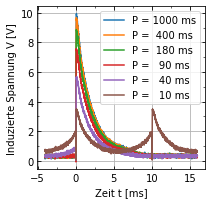

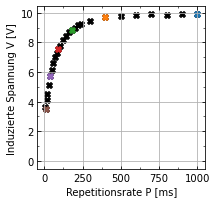

In [16]:
split=True
if not split:
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
else:
    fig1, (ax) = plt.subplots(figsize=(3, 3))
    fig2, (bx) = plt.subplots(figsize=(3, 3))

inds = [0, 6, 11, 16, 21, 25]
data.plot(x="time",y=[labels[i] for i in inds], ax=ax,
          label=[f'P = {P1[i]:4.0f} ms' for i in inds])
ax.set_xlabel("Zeit t [ms]")
ax.set_ylabel("Induzierte Spannung V [V]")
ax.legend()

bx.scatter(P1, M1, color='black',marker='X')
for idx in inds:
    bx.scatter(P1[idx], M1[idx], marker='X')
bx.set_xlabel("Repetitionsrate P [ms]")
bx.set_ylabel("Induzierte Spannung V [V]")
bx.set_ylim(*ax.get_ylim())

#bx.plot(P, res.best_fit)
#bx.hlines(M0, xmin=0, xmax=1000, color='gray',ls='--')
#bx.vlines(T1, ymin=0, ymax=10, color='gray',ls='--')
#print(f'{T1=} ms')

ax.grid()
bx.grid()
ticks_handle(ax, which='both')
ticks_handle(bx, which='both')

if not split:
    fig.savefig('IMAGES/lmo_t1_periode.png', dpi=300, bbox_inches='tight')
else:
    fig1.savefig('IMAGES/lmo_t1_periode_a.png', dpi=300,bbox_inches='tight')
    fig2.savefig('IMAGES/lmo_t1_periode_b.png', dpi=300,bbox_inches='tight')
plt.show()

## T1 aus Echo-Methode

Daten: Tag 1, meas == H, Tau ungeüngedner Bereich

Data day two: meas == L

In [17]:
path = 'data_day_two'
file_list = fo.load_file_list(path)
selection = (fo.select_files(file_list,'meas','L'))
data = fo.load_files(selection)
for d in data:
    d['time'] = d['time']*1000

idx = [d['signal'].idxmax() for d in data]
M2 = np.array([d.loc[i, 'signal'] for i,d in zip(idx, data)])
P2 = np.array([d.loc[i, 'time'] for i,d in zip(idx, data)])

In [18]:
M2[17] = 0.43
P2[17] = 36
ran = list(range(45))
ran.remove(34)
ran.remove(38)

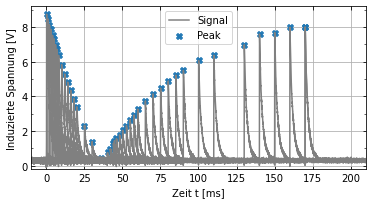

In [19]:
fig,ax = plt.subplots(figsize=(6,3))
for i in ran:
    ax.plot(data[i]['time'], data[i]['signal'], color='gray', label=('Signal' if i == 0 else None) )
ax.scatter(P2[ran], M2[ran],marker='X', label='Peak', zorder=2)
ax.grid()
ticks_handle(ax, which='both')
ax.set_xlabel('Zeit t [ms]')
ax.set_xlim(-10, 210)
ax.set_ylabel('Induzierte Spannung [V]')
ax.set_ylim(-0.2,9.2)
ax.legend()
fig.savefig('IMAGES/lmo_t1_echo.png', dpi=300, bbox_inches='tight')

## Fit T1

In [20]:
def fit_t1(t, y, log=False):
    ''' clean function. '''
    def fitfunc(t, M0, T1):
        return M0*(1-np.exp(-t/T1))

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, M0=10, T1=10)
    if log: print(res.fit_report())
    return res

def fit_t1_toffset(t, y, log=False):
    ''' fitfunciton with timeoffsest'''
    def fitfunc(t, M0, T1,c):
        return M0*(1-np.exp(-(t+c)/T1))

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, M0=10, T1=10,c=0)
    if log: print(res.fit_report())
    return res

def fit_t1_m0const(t, y,M0, log=False):
    ''' fit function with static M0'''
    def fitfunc(t, T1):
        return M0*(1-np.exp(-t/T1))

    model = Model(fitfunc, nan_policy='omit')
    res = model.fit(y, t=t, T1=10)
    if log: print(res.fit_report())
    return res

In [21]:
# handle data from P
res1 = fit_t1(P1,M1) # original function
res1b = fit_t1_m0const(P1,M1, M0=np.mean(M1[:6])) # with fixed m0

In [22]:
# handle data from Echo
p3 = np.copy(P2[ran])
m3 = np.copy(M2[ran])
imin = m3.argmin()
m3 = np.append(-1 * m3[:imin], m3[imin:])

res2 = fit_t1_toffset(p3, m3)

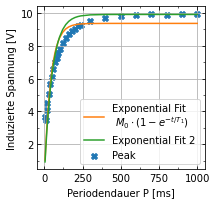

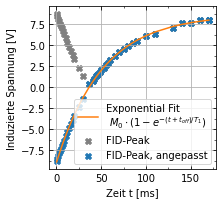

In [23]:
split=True
if not split:
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(6, 3))
else:
    fig1, (ax) = plt.subplots(figsize=(3, 3))
    fig2, (bx) = plt.subplots(figsize=(3, 3))

ax.scatter(P1,M1, label='Peak',marker='X',)
next(ax._get_lines.prop_cycler)['color']
ax.plot(P1, res1.best_fit, label='Exponential Fit\n $M_0\cdot(1-e^{-t/T_1})$')
ax.plot(P1, res1b.best_fit, label='Exponential Fit 2')
ax.set_xlabel('Periodendauer P [ms]')


bx.scatter(P2[ran], M2[ran], label='FID-Peak',marker='X',color='grey')
bx.scatter(p3, m3, label='FID-Peak, angepasst',marker='X',)

next(bx._get_lines.prop_cycler)['color']
bx.plot(p3, res2.best_fit , label='Exponential Fit\n $M_0\cdot(1-e^{-(t+t_{off})/T_1})$')

bx.set_xlabel('Zeit t [ms]')

for xx in [ax,bx]:
    #xx.set_ylim(-0.2,10.2)
    ticks_handle(xx, which='both')
    xx.grid()
    xx.legend(loc='lower right')
    xx.set_ylabel('Induzierte Spannung [V]')
    

if not split:
    fig.savefig('IMAGES/lmo_t1_fit.png', dpi=300, bbox_inches='tight')
else:
    fig1.savefig('IMAGES/lmo_t1_fit_P.png', dpi=300, bbox_inches='tight')
    fig2.savefig('IMAGES/lmo_t1_fit_E.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
print(res1.fit_report())

[[Model]]
    Model(fitfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 27
    # variables        = 2
    chi-square         = 16.9728017
    reduced chi-square = 0.67891207
    Akaike info crit   = -8.53406696
    Bayesian info crit = -5.94239323
[[Variables]]
    M0:  9.36154480 +/- 0.22588071 (2.41%) (init = 10)
    T1:  42.2522198 +/- 4.40824768 (10.43%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(M0, T1) = 0.568


In [25]:
print(res1b.fit_report())

[[Model]]
    Model(fitfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 27
    # variables        = 1
    chi-square         = 20.2165440
    reduced chi-square = 0.77755938
    Akaike info crit   = -5.81206085
    Bayesian info crit = -4.51622398
[[Variables]]
    T1:  50.5555519 +/- 4.16799651 (8.24%) (init = 10)


In [26]:
print(res2.fit_report())

[[Model]]
    Model(fitfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 43
    # variables        = 3
    chi-square         = 0.73937755
    reduced chi-square = 0.01848444
    Akaike info crit   = -168.715308
    Bayesian info crit = -163.431708
[[Variables]]
    M0:  8.59519341 +/- 0.07790101 (0.91%) (init = 10)
    T1:  51.0614971 +/- 0.59908470 (1.17%) (init = 10)
    c:  -36.4040510 +/- 0.18311868 (0.50%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(M0, T1) = 0.872
    C(T1, c)  = -0.740
    C(M0, c)  = -0.476
